In [1]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
clip = False

## Load the data

In [2]:
census_path = 'data/census_data.csv'
indicators_path = 'data/tracts_indicators_grades.csv'
tracts_path = 'data/tracts_shapefile'
output_path = 'data/tracts_indicators_grades_eras_index.csv'
crs = {'init':'epsg:4326'}

In [3]:
indicators = pd.read_csv(indicators_path, dtype={'geoid':str})
cd = pd.read_csv(census_path, dtype={'geoid':str, 'state':str, 'county':str})
indicators = pd.merge(indicators, cd, left_on='geoid', right_on='geoid')
len(indicators)

72663

In [4]:
tracts = gpd.read_file(tracts_path, crs=crs).rename(columns={'ALAND':'aland'})[['GEOID', 'aland']]

In [5]:
gdf = gpd.GeoDataFrame(pd.merge(indicators, tracts, left_on='geoid', right_on='GEOID'), crs=crs)
gdf = gdf.drop(columns=['GEOID'])
len(gdf)

72663

In [6]:
with open('data/states_by_fips.json') as f:
    fips_to_state = json.load(f)
gdf['state_abbrev'] = gdf['state'].map(lambda x: fips_to_state[x]['abbreviation'])

In [7]:
gdf.head()

,geoid,orientation_order,orientation_entropy,circuity_avg,k_avg,prop_deadend,prop_4way,m,n,length_median,...,prop_1960_69,prop_1970_79,prop_1980_89,prop_1990_99,prop_2000_09,prop_2010_later,state,county,aland,state_abbrev
0,01001020100,0.133914,3.431114,1.056441,2.297143,0.274286,0.062857,201,175,137.2530,...,0.129,0.207,0.254,0.161,0.078,0.000,01,001,9817812,AL
1,01001020200,0.593215,2.787678,1.026853,2.510949,0.218978,0.175182,172,137,123.5930,...,0.171,0.325,0.028,0.117,0.159,0.000,01,001,3325679,AL
2,01001020300,0.458073,3.003797,1.045833,2.449438,0.241573,0.174157,218,178,122.2380,...,0.177,0.369,0.075,0.157,0.132,0.031,01,001,5349273,AL
3,01001020400,0.277759,3.253601,1.054723,2.729730,0.171171,0.207207,303,222,115.9710,...,0.359,0.295,0.048,0.117,0.018,0.019,01,001,6384276,AL
4,01001020500,0.218907,3.328190,1.089604,2.446701,0.307107,0.139594,482,394,107.4215,...,0.029,0.027,0.110,0.338,0.448,0.049,01,001,11408873,AL


## Create and convert variables

In [8]:
# convert land area and densities to square kilometers
gdf['aland'] = gdf['aland'] / 1e6 #convert m2 to km2
gdf['intersect_density'] = (gdf['n'] / gdf['aland']) * (1 - gdf['prop_deadend']) #per km2
gdf['pop_density'] = gdf['total_pop'] / gdf['aland'] #per km2
gdf['aland'] = gdf['aland'] / 1000 #finally convert km2 to 1000s of km2

In [9]:
# population in units of 1,000 persons
gdf['total_pop_k'] = gdf['total_pop'] / 1000

In [10]:
# log of mean street segment length
gdf['length_mean_log'] = np.log(gdf['length_mean'])

In [11]:
# straightness is inverse of circuity
gdf['straightness'] = 1 / gdf['circuity_avg']

In [12]:
# create state dummies
states = gdf['state_abbrev'].unique()
for state in states:
    gdf[state] = gdf['state_abbrev'].map(lambda x: 1 if x==state else 0)

In [13]:
# dummy for if tract is rural vs urban
# census bureau considers a block urban if it has at least 1000 people per sq mile
urban_density = 1000 / 2.59 # 1000 people per sq mile converted to sq km
gdf['is_urban'] = (gdf['pop_density'] > urban_density).astype(int)
gdf['is_urban'].value_counts()

1    46311
0    26352
Name: is_urban, dtype: int64

## Create grid index

In [14]:
index_components = ['orientation_order', 'straightness', 'prop_4way']
gdf[index_components].describe()

,orientation_order,straightness,prop_4way
count,72659.000000,72663.000000,72663.000000
mean,0.484327,0.935759,0.210324
std,0.316234,0.045987,0.171770
min,0.002183,0.000000,0.000000
25%,0.185824,0.911671,0.092486
50%,0.465526,0.939706,0.156627
75%,0.772004,0.969004,0.271676
max,1.000000,1.000007,1.000000


In [15]:
# clip vectors to 4 std devs above/below mean to make variances more similar
if clip:
    sigma = 4
    for col in index_components:
        lower = gdf[col].mean() - gdf[col].std() * sigma
        upper = gdf[col].mean() + gdf[col].std() * sigma
        gdf[col] = gdf[col].clip(lower, upper)

    # min-max scale to get them back into (0,1) range
    gdf[index_components] = (gdf[index_components]-gdf[index_components].min())/(gdf[index_components].max()-gdf[index_components].min())
    print(gdf[index_components].describe())

In [16]:
# fix any rounding errors so all three components are in range 0 to 1
gdf[index_components] = gdf[index_components].clip(lower=0, upper=1)
gdf[index_components].describe()

,orientation_order,straightness,prop_4way
count,72659.000000,72663.000000,72663.000000
mean,0.484327,0.935759,0.210324
std,0.316234,0.045987,0.171770
min,0.002183,0.000000,0.000000
25%,0.185824,0.911671,0.092486
50%,0.465526,0.939706,0.156627
75%,0.772004,0.969004,0.271676
max,1.000000,1.000000,1.000000


In [17]:
# or standardized (mean-normalized) version with mean=0 and std=1
gdf_norm = (gdf[index_components] - gdf[index_components].mean()) / gdf[index_components].std()
gdf_norm.describe()

,orientation_order,straightness,prop_4way
count,7.265900e+04,7.266300e+04,7.266300e+04
mean,-1.649854e-14,-3.982827e-14,-4.095612e-14
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.524643e+00,-2.034848e+01,-1.224456e+00
25%,-9.439324e-01,-5.238102e-01,-6.860279e-01
50%,-5.945437e-02,8.582047e-02,-3.126153e-01
75%,9.096941e-01,7.229103e-01,3.571758e-01
max,1.630668e+00,1.396937e+00,4.597294e+00


create index: the component indicators are non-substitutable/non-compensatory. that means, ideally you'd use geometric mean. but you can only do that if all components are positive (due to the cube-root). with the mean-zero normalized data, some will be negative. so, do arithmetic mean of mean-normalized data and geometric mean of standard 0,1 data (which is essentially min-max normalized).

In [18]:
# arithmetic mean, even-weighting of mean-normalized components (gdf_norm)
gdf['grid_index'] = gdf_norm[index_components].sum(axis=1) / 3

# geometric mean, even-weighting of min-max-normalized components (gdf)
gdf['grid_index_geom'] = stats.mstats.gmean(gdf[index_components], axis=1)

G:\Anaconda\envs\ox\lib\site-packages\scipy\stats\stats.py:308: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [19]:
sample = gdf.sample(n=6, random_state=2)
sample[['geoid', 'state_abbrev', 'grid_index', 'grid_index_geom'] + index_components]

,geoid,state_abbrev,grid_index,grid_index_geom,orientation_order,straightness,prop_4way
25412,18177000800,IN,0.687643,0.600108,0.743488,0.968931,0.300000
31086,25001014700,MA,-0.841450,0.336798,0.267217,0.863212,0.165625
71361,55025011506,WI,-0.305263,0.401471,0.323960,0.914820,0.218341
9300,06073005700,CA,1.976660,0.905874,0.991945,0.987850,0.758621
17211,12099007833,FL,-0.006759,0.524014,0.768401,0.893731,0.209524
12809,08123002018,CO,0.258005,0.463627,0.835084,0.942767,0.126582


In [20]:
# want component indicators that are relevant but not too redundant (ie, strongly correlated)
# here, we see each of our indicators is more strongly correlated with the index than with each other: good
gdf[['grid_index', 'grid_index_geom'] + index_components].corr()

,grid_index,grid_index_geom,orientation_order,straightness,prop_4way
grid_index,1.000000,0.954403,0.870568,0.835172,0.873673
grid_index_geom,0.954403,1.000000,0.899478,0.663511,0.900373
orientation_order,0.870568,0.899478,1.000000,0.576998,0.669655
straightness,0.835172,0.663511,0.576998,1.000000,0.582524
prop_4way,0.873673,0.900373,0.669655,0.582524,1.000000


## Make era dummies then inspect our columns

In [21]:
cols = ['prop_1939_earlier', 'prop_1940_49', 'prop_1950_59', 'prop_1960_69', 
        'prop_1970_79', 'prop_1980_89', 'prop_1990_99', 'prop_2000_09', 'prop_2010_later']

# jitter so we don't get 2 eras with equal value and both are the plurality
np.random.seed(0)
gdf[cols] = gdf[cols].applymap(lambda x: x + np.random.random() * 1e-6)

In [22]:
%%time
# identify the primary decade algorithmically
def find_earliest_threshold(row, cols, threshold):
    for col in cols:
        if row[col] > threshold:
            return col

def determine_primary_decade(row, cols=cols):
    for threshold in [0.5, 0.4, 0.3, 0.2, 0.1]:
        decade = find_earliest_threshold(row, cols, threshold)
        if decade is not None:
            return decade

gdf['primary_decade'] = gdf.apply(determine_primary_decade, axis='columns')
primary_dummies = pd.get_dummies(gdf['primary_decade'], prefix='dummy_primary')
gdf[primary_dummies.columns] = primary_dummies

Wall time: 9.14 s


In [23]:
%%time
# identify earliest decade by which cumulatively >50% of tract's structures were built
def determine_earliest_cumulative_decade(row):
    for col in cols:
        if row[col]:
            return col

cs = gdf[cols].cumsum(axis='columns') > 0.50
gdf['cumulative_decade'] = cs.apply(determine_earliest_cumulative_decade, axis='columns')
cumulative_dummies = pd.get_dummies(gdf['cumulative_decade'], prefix='dummy_cumulative')
gdf[cumulative_dummies.columns] = cumulative_dummies

Wall time: 2.2 s


In [24]:
%%time
# identify earliest decade in which >20% of tract's structures were built
def determine_earliest_decade(row, threshold=0.20):
    for col in cols:
        if row[col] > threshold:
            return col
    
gdf['earliest_decade'] = gdf.apply(determine_earliest_decade, axis='columns')
earliest_dummies = pd.get_dummies(gdf['earliest_decade'], prefix='dummy_earliest')
gdf[earliest_dummies.columns] = earliest_dummies

Wall time: 2.39 s


In [25]:
%%time
# identify decade in which plurality of tract's structures were built
def determine_plurality_decade(row):
    for col in cols:
        other_cols = [c for c in cols if c != col]
        if (row[col] > row[other_cols]).all():
            return col

gdf['plurality_decade'] = gdf.apply(determine_plurality_decade, axis='columns')
plurality_dummies = pd.get_dummies(gdf['plurality_decade'], prefix='dummy_plurality')
gdf[plurality_dummies.columns] = plurality_dummies

Wall time: 5min 5s


In [26]:
%%time
# identify decade in which majority of tract's structures were built (where a majority exists)
def determine_majority_decade(row):
    for col in cols:
        if row[col] > 0.5:
            return col

gdf['majority_decade'] = gdf.apply(determine_majority_decade, axis='columns')
majority_dummies = pd.get_dummies(gdf['majority_decade'], prefix='dummy_majority')
gdf[majority_dummies.columns] = majority_dummies

Wall time: 3.99 s


In [27]:
decades = ['majority_decade', 'plurality_decade', 'earliest_decade', 'cumulative_decade', 'primary_decade']
gdf[decades].apply(lambda x: x.value_counts())

,majority_decade,plurality_decade,earliest_decade,cumulative_decade,primary_decade
prop_1939_earlier,5790,18079,19673,5790,21222
prop_1940_49,77,1159,1651,3968,1501
prop_1950_59,1211,8512,8564,9773,9219
prop_1960_69,550,5335,5726,10516,5584
prop_1970_79,1181,12557,12814,16487,12428
prop_1980_89,980,7345,7067,13702,6855
prop_1990_99,1082,9022,8255,8570,7813
prop_2000_09,2046,9954,4632,3392,7435
prop_2010_later,40,274,76,39,180


In [28]:
def fstr(x):
    try:
        return f'{x:0.3f}'
    except:
        return x
    
gdf[cols + decades].sample(n=5, random_state=2).applymap(fstr)

,prop_1939_earlier,prop_1940_49,prop_1950_59,prop_1960_69,prop_1970_79,prop_1980_89,prop_1990_99,prop_2000_09,prop_2010_later,majority_decade,plurality_decade,earliest_decade,cumulative_decade,primary_decade
25412,0.213,0.135,0.273,0.069,0.188,0.076,0.041,0.005,0.000,None,prop_1950_59,prop_1939_earlier,prop_1950_59,prop_1939_earlier
31086,0.047,0.045,0.186,0.210,0.266,0.121,0.046,0.076,0.003,None,prop_1970_79,prop_1960_69,prop_1970_79,prop_1960_69
71361,0.040,0.024,0.032,0.054,0.109,0.136,0.227,0.295,0.083,None,prop_2000_09,prop_1990_99,prop_1990_99,prop_1990_99
9300,0.386,0.066,0.071,0.080,0.264,0.086,0.029,0.019,0.000,None,prop_1939_earlier,prop_1939_earlier,prop_1950_59,prop_1939_earlier
17211,0.000,0.000,0.000,0.003,0.121,0.509,0.238,0.130,0.000,prop_1980_89,prop_1980_89,prop_1980_89,prop_1980_89,prop_1980_89


In [29]:
gdf[gdf['primary_decade'] != gdf['earliest_decade']][cols + decades].applymap(fstr).head()

,prop_1939_earlier,prop_1940_49,prop_1950_59,prop_1960_69,prop_1970_79,prop_1980_89,prop_1990_99,prop_2000_09,prop_2010_later,majority_decade,plurality_decade,earliest_decade,cumulative_decade,primary_decade
4,0.000,0.000,0.000,0.029,0.027,0.110,0.338,0.448,0.049,None,prop_2000_09,prop_1990_99,prop_1990_99,prop_2000_09
7,0.048,0.021,0.029,0.011,0.156,0.188,0.214,0.300,0.033,None,prop_2000_09,prop_1990_99,prop_1990_99,prop_2000_09
8,0.020,0.015,0.017,0.053,0.107,0.101,0.235,0.318,0.136,None,prop_2000_09,prop_1990_99,prop_1990_99,prop_2000_09
18,0.004,0.003,0.021,0.085,0.107,0.206,0.353,0.156,0.066,None,prop_1990_99,prop_1980_89,prop_1990_99,prop_1990_99
19,0.005,0.000,0.008,0.013,0.011,0.077,0.203,0.518,0.164,prop_2000_09,prop_2000_09,prop_1990_99,prop_2000_09,prop_2000_09


In [30]:
# not every tract has residential strutures
pd.isnull(gdf['primary_decade']).sum()

426

In [31]:
str(gdf.columns.sort_values().tolist())

"['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'aland', 'available_vehicles', 'circuity_avg', 'county', 'cumulative_decade', 'dummy_cumulative_prop_1939_earlier', 'dummy_cumulative_prop_1940_49', 'dummy_cumulative_prop_1950_59', 'dummy_cumulative_prop_1960_69', 'dummy_cumulative_prop_1970_79', 'dummy_cumulative_prop_1980_89', 'dummy_cumulative_prop_1990_99', 'dummy_cumulative_prop_2000_09', 'dummy_cumulative_prop_2010_later', 'dummy_earliest_prop_1939_earlier', 'dummy_earliest_prop_1940_49', 'dummy_earliest_prop_1950_59', 'dummy_earliest_prop_1960_69', 'dummy_earliest_prop_1970_79', 'dummy_earliest_prop_1980_89', 'dummy_earliest_prop_1990_99', 'dummy_earliest_prop_2000_09', 'dummy_earliest_prop_2010_later', 'dummy_majority_prop_1

In [32]:
gdf.to_csv(output_path, index=False, encoding='utf-8')

## Look at individual stats

In [33]:
gdf['grid_index_geom'].describe()

count    72659.000000
mean         0.420893
std          0.208963
min          0.000000
25%          0.255690
50%          0.395729
75%          0.560829
max          1.000000
Name: grid_index_geom, dtype: float64

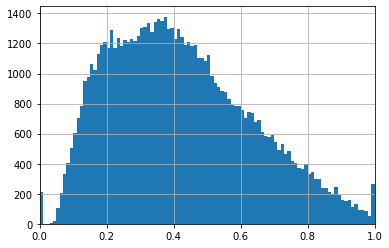

In [34]:
ax = gdf['grid_index_geom'].hist(bins=100)
ax.set_xlim((0,1))
plt.show()

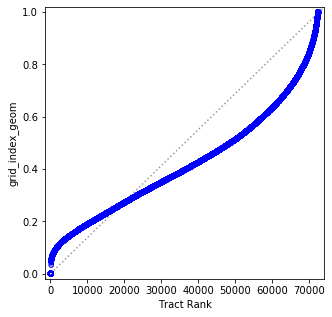

In [35]:
y = gdf['grid_index_geom'].sort_values()
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x=range(len(y)), y=y, s=20, marker='o', edgecolor='b', color='none', alpha=0.7)
xmax = int(len(gdf) * 1.02)
xmin = int(len(gdf) * -0.02)
ymax = 1.02
ymin = -0.02
plt.plot([xmin, xmax], [ymin, ymax], c='#999999', ls=':', zorder=-1)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.set_ylabel('grid_index_geom')
ax.set_xlabel('Tract Rank')
plt.show()

In [36]:
print(gdf.groupby('state_abbrev')[['grid_index_geom', 'prop_4way']].median().sort_values('prop_4way').head(10))
print(gdf.groupby('state_abbrev')[['grid_index_geom', 'prop_4way']].median().sort_values('prop_4way').tail(10))

              grid_index_geom  prop_4way
state_abbrev                            
VT                   0.133404   0.041848
ME                   0.168120   0.053036
WV                   0.146079   0.063733
NH                   0.163854   0.066398
CT                   0.245456   0.083333
AK                   0.285602   0.093240
SC                   0.196871   0.095384
NC                   0.203051   0.095620
KY                   0.210008   0.095833
GA                   0.227849   0.096774
              grid_index_geom  prop_4way
state_abbrev                            
MN                   0.472955   0.208930
WI                   0.488544   0.217742
KS                   0.542350   0.234471
ND                   0.546871   0.242424
NY                   0.523570   0.245614
IL                   0.567816   0.257874
NE                   0.554861   0.261051
IA                   0.580245   0.268728
SD                   0.581577   0.273522
DC                   0.627500   0.366337


In [37]:
# total nodes and edges in dataset 
print('{:,}'.format(gdf['m'].sum()))
print('{:,}'.format(gdf['n'].sum()))

23,535,182
18,942,521


In [38]:
variables = ['grid_index_geom', 'straightness', 'orientation_order', 'prop_4way',
             'aland', 'total_pop_k', 'is_urban', 'prop_single_fam', 'med_rooms_per_home', 
             'intersect_density', 'length_mean', 'prop_deadend', 'k_avg',
             'elevations_iqr', 'grade_mean']

gdf[variables].corr()

,grid_index_geom,straightness,orientation_order,prop_4way,aland,total_pop_k,is_urban,prop_single_fam,med_rooms_per_home,intersect_density,length_mean,prop_deadend,k_avg,elevations_iqr,grade_mean
grid_index_geom,1.000000,0.663511,0.899478,0.900373,-0.174964,-0.169927,0.420581,-0.323275,-0.362921,0.570755,-0.265833,-0.735248,0.627165,-0.304589,-0.376600
straightness,0.663511,1.000000,0.576998,0.582524,-0.174061,-0.124795,0.235659,-0.170584,-0.200391,0.412630,-0.178465,-0.509930,0.420942,-0.335524,-0.275154
orientation_order,0.899478,0.576998,1.000000,0.669655,-0.154421,-0.174282,0.369453,-0.259875,-0.344386,0.464086,-0.208365,-0.597286,0.432192,-0.298608,-0.416461
prop_4way,0.900373,0.582524,0.669655,1.000000,-0.155383,-0.152566,0.376718,-0.350046,-0.330237,0.570924,-0.247403,-0.707588,0.632320,-0.225315,-0.250803
aland,-0.174964,-0.174061,-0.154421,-0.155383,1.000000,-0.072429,-0.405322,0.158351,0.009575,-0.310210,0.676344,0.266570,-0.109554,0.509484,0.032459
total_pop_k,-0.169927,-0.124795,-0.174282,-0.152566,-0.072429,1.000000,0.037260,0.067103,0.129846,-0.101022,-0.105133,0.144669,-0.007636,-0.030351,-0.026237
is_urban,0.420581,0.235659,0.369453,0.376718,-0.405322,0.037260,1.000000,-0.338166,-0.192626,0.660140,-0.580761,-0.480054,0.268728,-0.309231,-0.127561
prop_single_fam,-0.323275,-0.170584,-0.259875,-0.350046,0.158351,0.067103,-0.338166,1.000000,0.693394,-0.469307,0.282403,0.369143,-0.060878,0.147664,0.066406
med_rooms_per_home,-0.362921,-0.200391,-0.344386,-0.330237,0.009575,0.129846,-0.192626,0.693394,1.000000,-0.322798,0.122862,0.328736,-0.127503,0.064006,0.121355
intersect_density,0.570755,0.412630,0.464086,0.570924,-0.310210,-0.101022,0.660140,-0.469307,-0.322798,1.000000,-0.515904,-0.620580,0.404717,-0.260130,-0.120502


In [39]:
mask_urban = (gdf['state_abbrev'].isin(states)) & (gdf['is_urban'] == 1)
mask_rural = (gdf['state_abbrev'].isin(states)) & (gdf['is_urban'] == 0)
print(gdf[mask_urban]['grid_index_geom'].median())
print(gdf[mask_rural]['grid_index_geom'].median())

0.46319303645203613
0.27312788049609876


In [40]:
ne = ['ME', 'VT', 'NH', 'MA', 'RI', 'CT', 'NJ', 'PA', 'NY']
mask_urban = (gdf['state_abbrev'].isin(ne)) & (gdf['is_urban'] == 1)
mask_rural = (gdf['state_abbrev'].isin(ne)) & (gdf['is_urban'] == 0)
print(gdf[mask_urban]['grid_index_geom'].median())
print(gdf[mask_rural]['grid_index_geom'].median())

0.4852303123331175
0.18133625719382995


In [41]:
plains = ['ND', 'SD', 'NE', 'KS', 'OK']
mask_urban = (gdf['state_abbrev'].isin(plains)) & (gdf['is_urban'] == 1)
mask_rural = (gdf['state_abbrev'].isin(plains)) & (gdf['is_urban'] == 0)
print(gdf[mask_urban]['grid_index_geom'].median())
print(gdf[mask_rural]['grid_index_geom'].median())

0.5182428767902837
0.5173990210986679
